In [692]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
import statsmodels.api as sm
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pickle


## Model Maker Class

In [693]:
class aviation_data_model:
    def __init__(self, x, y, drop_categories = None, test_size = 0.3, random_state = 2023):
        self.x = x.copy()
        self.drop_categories = drop_categories
        self.y = y
        self.random_state = random_state
        self.test_size = test_size
        self.model = None
        self.x_oh = None
        self.x_con = None
        self.results = None
        self.pvalues = None
        self.X_test = None
        self.Y_test = None

        
    def one_hot(self):
        #Check to see if dummy parameter passed correctly
        if type(self.drop_categories[0]) == tuple:
            
            categories = []
            for i, j in self.drop_categories:
                # Collect subset of columns to dummify
                categories.append(i)
                
                # If a specific drop value has been given for a column, add a 0- to it so it is 'first' and drops accordingly
                if j != 'first':
                    self.x[i] = np.where(self.x[i] == j, '0-' + j, self.x[i])
        else:
            raise TypeError('Invalid OneHotEncoder values. Use None or a list of tuples of (column name, category name')
            
        self.x_oh = pd.get_dummies(data= self.x, columns = categories, drop_first=True)
        # Log line - uncomment below to check shapes after important steps
        # print(f"OneHot Resulting Shape: {self.x_oh.shape}")
        return self.x_oh
    
    def train_test(self, x, y):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=self.test_size, random_state=self.random_state)
        return (X_train, X_test, y_train, y_test)
        
    
    def fit_binomial(self, link = 'logit'):
        # Start with OneHotEncoding if given
        if self.drop_categories:
            model_x = self.one_hot()
        else:
            model_x = self.x
            
        # Add column for constant per statsmodels GLM requirements
        x_con = sm.add_constant(model_x[list(model_x.columns)])
        self.x_con = x_con
        
        # Log line - uncomment below to check shapes after important steps
        # print(f"After constant Resulting Shape: {self.x_con.shape}")
        
        #Train Test Split
        X_train, X_test, y_train, y_test = self.train_test(x_con, self.y)

        
        # Log lines - uncomment below to check shapes after important steps
        # print(f"After tts X_train Resulting Shape: {X_train.shape}")
        # print(f"After tts X_test Resulting Shape: {X_test.shape}")
        # print(f"After tts y_train Resulting Shape: {y_train.shape}")
        # print(f"After tts y_test Resulting Shape: {y_test.shape}")
        
        if link == 'logit':
            link_function = sm.families.links.Logit()
        elif link == 'probit':
            link_function = sm.families.links.Probit()
        
        #Make and fit a model
        glm_bin = sm.GLM(
            y_train,
            X_train,
            family=sm.families.Binomial(link=link_function)).fit()
        
        #Stash results as accessible attributes
        self.results = glm_bin.summary()
        self.model = glm_bin
        self.pvalues = np.round(glm_bin.pvalues, 6).to_frame().sort_values(by = 0)
        self.pvalues.rename({0: 'p_values'}, axis =1 , inplace=True)
        self.X_test = X_test
        self.y_test = y_test

In [694]:
def glm_accuracy(model, x, y):
    test_pred = model.predict(x)
    test_pred = test_pred.map(lambda x: 1 if x >=0.50 else 0)
    acc = pd.concat([test_pred, y], axis = 1)
    return acc[acc.iloc[:, 0] == acc.iloc[:, 1]].shape[0] / y.shape[0]

In [695]:
def is_top_model(data, model, top_x):
    top_list = list(data['model'].value_counts()[:top_x + 1].index.str.upper())
    return True if model.upper() in top_list else False

In [696]:
def is_top_make(data, make, top_x):
    top_list = list(data['make'].value_counts()[:top_x + 1].index.str.upper())
    return True if make.upper() in top_list else False

In [697]:
def is_top_family(data, family, top_x):
    top_list = list(data['aircraft_family'].value_counts()[:top_x + 1].index.str.upper())
    return True if family.upper() in top_list else False

In [698]:
def is_top_city(data, city, top_x):
    top_list = list(data['city'].value_counts()[:top_x + 1].index.str.upper())
    return True if city.upper() in top_list else False

In [699]:
# def bundler(val, top_n):
#     top_list = list(data.value_counts()[:top_n + 1].index.str.upper())
#     new_data = np.where(data.str.upper().isin(top_list), data.str.upper(), 'UNCOMMON' )
#     return new_data

### Read in data

In [700]:
df = pd.read_csv('../datasets/alaska_single_engine_clean.csv')

In [701]:
len(df['model'].unique())

1053

## Double check 

In [702]:
df['highest_injury_level'].value_counts()

None Reported    4008
Minor             626
Fatal             577
Serious           379
Name: highest_injury_level, dtype: int64

In [703]:
df['aircraft_damage'].value_counts()

Substantial      4916
Destroyed         503
Minor             115
None Reported      52
Unknown             4
Name: aircraft_damage, dtype: int64

In [704]:
df['model'] = df['model'].str.upper()

In [705]:
df['make'] = df['make'].str.upper()

## Binarize, bundle, and engineer

Group 'UNK' and 'Unknown'

In [706]:
df['purpose_of_flight'] = df['purpose_of_flight'].map(lambda x: 'UNK' if x=='Unknown' else x)

In [707]:
df['scheduled'] = df['scheduled'].map(lambda x: 'UNK' if x == 'Unknown' else x)

The following lines are designed to help balance out categorical values, since there are many infrequent occurrences as well as very common occurrences. They set a cutoff in terms of the most frequent values, and anything outside of that gets lumped together as some variant of "Uncommon"

In [708]:
df['model'] = [x.upper() if is_top_model(df, x,200) else 'UNCOMMON MODEL' for x in df['model']]

In [709]:
df['make'] = [x.upper() if is_top_make(df, x,50) else 'UNCOMMON MAKE' for x in df['make']]


In [710]:
df['aircraft_family'] = [x.upper() if is_top_family(df, x,25) else 'UNCOMMON FAMILY' for x in df['aircraft_family']]

In [711]:
df['city'] = [x.upper() if is_top_city(df, x,75) else 'UNCOMMON CITY' for x in df['city']]

In [712]:
df['aircraft_category'].value_counts()

AIR         5271
HELI         303
ULTR           5
WSFT           4
GYRO           3
GLI            2
UNMANNED       1
PPAR           1
Name: aircraft_category, dtype: int64

### Drop everything that isn't a airplane or helicoper

In [713]:
df.drop( df[~df['aircraft_category'].isin(['AIR', 'HELI'])].index, inplace = True)

## Manual GLM Attempt with multiple features

### Create X

In [714]:
X_1a = df.drop(['ntsb_no', 'probable_cause', 'airport_name', 'event_type', 'mkey', 'city', 'n', 'has_safety_rec', 'report_type', 'highest_injury_level', 'fatal_injury_count', 'serious_injury_count', 'minor_injury_count', 'airport_id', 'far', 'aircraft_damage', 'operator', 'event_year', 'event_season', 'event_day', 'aircraft_category', 'has_injury', 'event_time','has_aircraft_damage', 'is_accident', 'make_model', 'aircraft_family'], axis=1)

In [715]:
X_1a.head()

,latitude,longitude,make,model,amateur_built,scheduled,purpose_of_flight,weather_condition,event_month,event_hour,occurred_near_airport
0,61.775160,-152.15263,CESSNA,UNCOMMON MODEL,0,UNK,PERS,Unknown,9,8,0
1,60.805019,-161.78648,PIPER,PA-18-150,0,UNK,PERS,Unknown,9,12,0
2,59.646929,-151.49323,CESSNA,A185F,0,UNK,BUS,VMC,9,13,1
3,64.267579,-147.68704,HELIO,H-295,0,NSCH,BUS,Unknown,9,16,0
4,64.650753,-149.83639,UNCOMMON MAKE,UNCOMMON MODEL,1,UNK,PERS,VMC,9,15,0


### Create Y

In [716]:
df['highest_injury_level'] = np.where(
    df['highest_injury_level'].str.contains('None Reported') |
    df['highest_injury_level'].str.contains('Minor'),
    0,
    1)

In [717]:
y = df['highest_injury_level']

In [718]:
baseline = 1 - y.mean()
baseline

0.8297452457839971

### Create dummies

In [719]:
X_1a_dummy = pd.get_dummies(data=X_1a,
                         columns=['make',
                                  'model',
                                  'scheduled',
                                  'purpose_of_flight',
                                  'weather_condition',
                                  'event_month',
                                  'event_hour'
                                 ],
                         drop_first=True
        )

In [720]:
X_1a_dummy.shape

(5574, 311)

### Add constant for use in GLM

In [721]:
X_1a_con = sm.add_constant(X_1a_dummy[list(X_1a_dummy.columns)])

In [722]:
X_1a_con.shape

(5574, 312)

### Train test split

In [723]:
X_train, X_test, y_train, y_test = train_test_split(X_1a_con, y, random_state=2023)

In [724]:
X_train.shape

(4180, 312)

In [725]:
glm_bin = sm.GLM(
    y_train,
    X_train,
    family=sm.families.Binomial(link=sm.families.links.Logit())).fit()

In [726]:
glm_bin_results = glm_bin.summary()

### Check accuracy

In [727]:
glm_accuracy(glm_bin, X_test, y_test)

0.8357245337159254

In [729]:
1 - y.mean()

0.8297452457839971

### Result: Accuracy does technically outperform baseline - p-values can kind of be trusted

(we will look at them anyway)

In [730]:
glm_bin_pvalues = np.round(glm_bin.pvalues, 4).to_frame().sort_values(by =  0, ascending = True)

In [741]:
glm_bin_coef_df = glm_bin.params.to_frame().sort_values(by = 0, ascending = False)

In [732]:
glm_bin_pvalues.rename({0: 'p_value'}, axis = 1, inplace=True)

In [733]:
glm_bin_coef_df.rename({0: 'coef'}, axis = 1, inplace=True)

In [738]:
glm_bin_pvalues.head(15)

,p_value
weather_condition_VMC,0.0000
occurred_near_airport,0.0000
event_hour_12,0.0005
event_hour_13,0.0024
event_hour_18,0.0031
event_hour_16,0.0031
event_hour_17,0.0035
event_hour_14,0.0074
event_hour_11,0.0076
event_hour_20,0.0091


In [743]:
glm_bin_coef_df.head(15)

,0
model_R-44,50.789791
purpose_of_flight_EXEC,27.643080
model_8KCAB,27.405438
purpose_of_flight_OWRK,26.615336
purpose_of_flight_FLTS,26.004445
purpose_of_flight_UNK,25.997125
purpose_of_flight_FERY,25.913559
purpose_of_flight_BUS,25.878223
model_R44 II,25.788007
purpose_of_flight_FIRF,25.698889


In [744]:
glm_bin_pvalues.to_csv('../results/glm_pvalues_manyfeatures_severe_and_fatal_y.csv')

## Trying again with modified Y

In [757]:
X_1b = df.drop(['ntsb_no', 'probable_cause', 'airport_name', 'event_type', 'mkey', 'n', 'has_safety_rec', 'report_type', 'highest_injury_level', 'fatal_injury_count', 'serious_injury_count', 'minor_injury_count', 'airport_id', 'far', 'aircraft_damage', 'operator', 'event_year', 'event_season', 'event_day', 'aircraft_category', 'has_injury', 'event_time','has_aircraft_damage', 'is_accident', 'make_model', 'make', 'model'], axis=1)

In [758]:
y = df['highest_injury_level']

In [766]:
X_1b.columns

Index(['city', 'latitude', 'longitude', 'amateur_built', 'scheduled',
       'purpose_of_flight', 'weather_condition', 'event_month', 'event_hour',
       'occurred_near_airport', 'aircraft_family'],
      dtype='object')

In [768]:
glm1z = aviation_data_model(X_1b, y, [
    ('city', 'first'),
    ('scheduled', 'UNK'),
    ('purpose_of_flight', 'UNK'),
    ('weather_condition', 'Unknown'),
    ('event_month', 'first'),
    ('event_hour', 'first'),
    ('aircraft_family', 'first')
], test_size=0.2)

In [769]:
glm1z.fit_binomial()

In [770]:
glm1z.X_test.shape

(1115, 132)

In [771]:
glm_accuracy(glm1z.model, glm1z.X_test, glm1z.y_test)

0.841255605381166

In [773]:
# glm1z.pvalues.to_csv('../results/glm_pvalues_largefeatureset2_severe_and_fatal_y_acc841.csv')

In [359]:
    def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
      
        matrix = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10,7))
        sns.heatmap(matrix, annot=True, fmt='g', cmap="Blues", 
                    xticklabels=['Predicted No Injuries', 'Predicted Injuries'], 
                    yticklabels=['Actually No Injuries', 'Actually Had Injuries'])
        plt.title(title)
        plt.show()

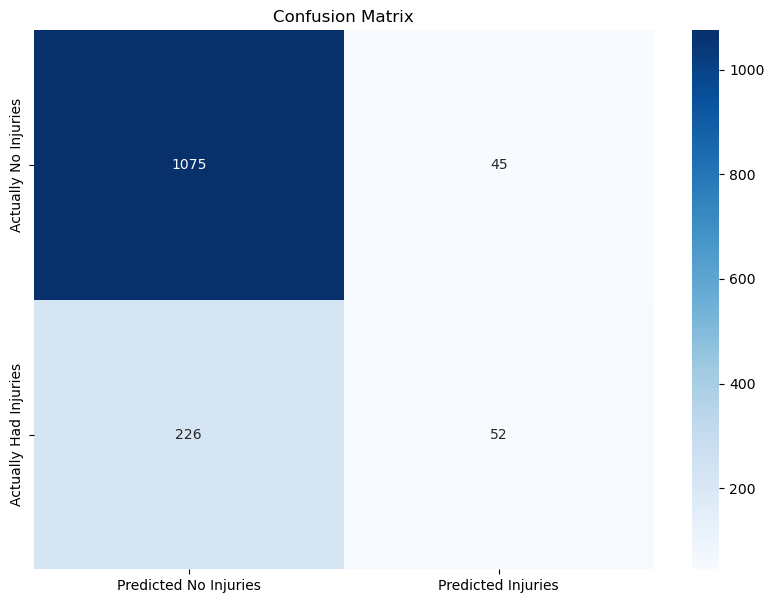

In [360]:
plot_confusion_matrix(y_test, test_pred)

## Round 2 - Rapid Fire P Values

## 1 - Weather Condition

In [369]:
y = df_glm1a['highest_injury_level']

In [370]:
X = df[['weather_condition']]

In [371]:
X.dtypes

weather_condition    object
dtype: object

In [372]:
y.value_counts()

0    4634
1     956
Name: highest_injury_level, dtype: int64

In [17]:
# X['purpose_of_flight'].value_counts()

In [380]:
glm1a = aviation_data_model(X, y,[
    ('weather_condition', 'Unknown')
])

In [381]:
glm1a.fit_binomial()

In [383]:
# glm1a.pvalues.to_csv('../results/glm_pvalues_weather_severe_and_fatal_y.csv')

In [377]:
np.exp(glm1a.model.params)

const                    1.750000
weather_condition_IMC    0.636735
weather_condition_VMC    0.085334
dtype: float64

## 2 - Aircraft Family

In [395]:
X_2 = df[['aircraft_family']]

In [396]:
y = df['highest_injury_level']

In [397]:
glm2a = aviation_data_model(X_2, y, drop_categories=[('aircraft_family', 'first')])

In [398]:
glm2a.fit_binomial()

In [399]:
glm2a_pvalues = glm2a.pvalues

In [400]:
glm2a_pvalues.head(10)

,p_values
aircraft_family_CESSNA 170,0.000903
const,0.003056
aircraft_family_CESSNA 180 SKYWAGON,0.005047
aircraft_family_PIPER PA-22 TRI-PACER,0.026309
aircraft_family_PIPER PA-18 SUPER CUB,0.044762
aircraft_family_CESSNA 152,0.066708
aircraft_family_PIPER PA-12 SUPER CRUISER,0.126637
aircraft_family_HELIO COURIER,0.135645
aircraft_family_CESSNA 185 SKYWAGON,0.156610
aircraft_family_CHAMPION/ BELLANCA/ AMERICAN CHAMPION SCOUT,0.171897


In [393]:
# glm2a_pvalues.to_csv('../results/glm_pvalues_aircraftfamily_severe_and_fatal_y.csv')

## 3 - Latitude and Longitude

In [407]:
X_3 = df[['latitude', 'longitude']]

In [401]:
y = df['highest_injury_level']

In [413]:
glm3a = aviation_data_model(X_3, y)

In [414]:
X_3.dtypes

latitude     float64
longitude    float64
dtype: object

In [416]:
glm3a.fit_binomial()

In [417]:
glm3a.pvalues

,p_values
const,0.000000
latitude,0.123706
longitude,0.257457


## 4 - City

In [431]:
X_4 = df[['city']]

In [432]:
y = df['highest_injury_level']

In [433]:
glm4a = aviation_data_model(X_4, y, [
    ('city', 'first')
])

In [434]:
glm4a.fit_binomial()

In [435]:
glm4a.pvalues

,p_values
const,0.000000
city_SITKA,0.000000
city_KODIAK,0.000000
city_KETCHIKAN,0.000000
city_NOME,0.000001
city_JUNEAU,0.000004
city_UNCOMMON CITY,0.000160
city_CANTWELL,0.005516
city_ILIAMNA,0.007662
city_ANIAK,0.011568


## Try out p values again but with modified y (any injury)

## 5 - Weather Condition

In [508]:
y = df['has_injury']

In [517]:
X_5 = df[['weather_condition']]

In [510]:
X.dtypes

weather_condition    object
dtype: object

In [511]:
y.value_counts()

0    4008
1    1582
Name: has_injury, dtype: int64

In [17]:
# X['purpose_of_flight'].value_counts()

In [518]:
glm5a = aviation_data_model(X_5, y,[
    ('weather_condition', 'Unknown')
])

In [513]:
glm5a.fit_binomial()

In [515]:
glm5a.pvalues

,p_values
weather_condition_VMC,0.000000
const,0.015430
weather_condition_IMC,0.714039


In [383]:
# glm1a.pvalues.to_csv('../results/glm_pvalues_weather_severe_and_fatal_y.csv')

In [514]:
np.exp(glm1a.model.params)

const                    1.750000
weather_condition_IMC    0.636735
weather_condition_VMC    0.085334
dtype: float64

## 6 - Aircraft Family

In [519]:
X_6 = df[['aircraft_family']]

In [520]:
y = df['has_injury']

In [521]:
glm6a = aviation_data_model(X_6, y, drop_categories=[('aircraft_family', 'first')])

In [522]:
glm6a.fit_binomial()

In [523]:
glm6a_pvalues = glm6a.pvalues

In [524]:
glm6a_pvalues.head(10)

,p_values
aircraft_family_CESSNA 170,0.000010
aircraft_family_CESSNA 180 SKYWAGON,0.000210
aircraft_family_PIPER PA-20 PACER,0.000917
aircraft_family_PIPER PA-22 TRI-PACER,0.001776
aircraft_family_PIPER PA-18 SUPER CUB,0.003355
aircraft_family_HELIO COURIER,0.013704
aircraft_family_CESSNA 185 SKYWAGON,0.021778
aircraft_family_CHAMPION/ BELLANCA/ AMERICAN CHAMPION SCOUT,0.034941
aircraft_family_PIPER PA-12 SUPER CRUISER,0.035389
aircraft_family_MAULE M-5,0.075717


In [393]:
# glm2a_pvalues.to_csv('../results/glm_pvalues_aircraftfamily_severe_and_fatal_y.csv')

## 7 - Latitude and Longitude

In [525]:
X_7 = df[['latitude', 'longitude']]

In [526]:
y = df['has_injury']

In [527]:
glm7a = aviation_data_model(X_7, y)

In [528]:
X_7.dtypes

latitude     float64
longitude    float64
dtype: object

In [529]:
glm7a.fit_binomial()

In [530]:
glm7a.pvalues

,p_values
const,0.000000
latitude,0.153246
longitude,0.315698


## 8 - City

In [531]:
X_8 = df[['city']]

In [532]:
y = df['has_injury']

In [533]:
glm8a = aviation_data_model(X_8, y, [
    ('city', 'first')
])

In [534]:
glm8a.fit_binomial()

In [535]:
glm8a.pvalues

,p_values
const,0.000000
city_KETCHIKAN,0.000016
city_NOME,0.000042
city_SITKA,0.000064
city_KODIAK,0.000336
city_UNCOMMON CITY,0.001345
city_JUNEAU,0.003285
city_CHUGIAK,0.018040
city_WASILLA,0.021570
city_PORT ALSWORTH,0.030418
